In [314]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from glob import glob

In [315]:
pd.set_option('display.max_columns', 80)

# import & prep df from 538

In [316]:
spi_url = 'https://projects.fivethirtyeight.com/soccer-api/club/spi_matches.csv'
spi = pd.read_csv(spi_url)

In [317]:
spi.head()

season        date  league_id                   league             team1  \
0    2016  2016-07-09       7921  FA Women's Super League   Liverpool Women   
1    2016  2016-07-10       7921  FA Women's Super League     Arsenal Women   
2    2016  2016-07-10       7921  FA Women's Super League  Chelsea FC Women   
3    2016  2016-07-16       7921  FA Women's Super League   Liverpool Women   
4    2016  2016-07-17       7921  FA Women's Super League  Chelsea FC Women   

                 team2   spi1   spi2   prob1   prob2  probtie  proj_score1  \
0              Reading  51.56  50.42  0.4389  0.2767   0.2844         1.39   
1  Notts County Ladies  46.61  54.03  0.3572  0.3608   0.2819         1.27   
2      Birmingham City  59.85  54.64  0.4799  0.2487   0.2714         1.53   
3  Notts County Ladies  53.00  52.35  0.4289  0.2699   0.3013         1.27   
4        Arsenal Women  59.43  60.99  0.4124  0.3157   0.2719         1.45   

   proj_score2  importance1  importance2  score1  score2  xg1  xg2  nsxg1  \
0         1.05          NaN          NaN     2.0     0.0  NaN  NaN    NaN   
1         1.28          NaN          NaN     2.0     0.0  NaN  NaN    NaN   
2         1.03          NaN          NaN     1.0     1.0  NaN  NaN    NaN   
3         0.94          NaN          NaN     0.0     0.0  NaN  NaN    NaN   
4         1.24          NaN          NaN     1.0     2.0  NaN  NaN    NaN   

   nsxg2  adj_score1  adj_score2  
0    NaN         NaN         NaN  
1    NaN         NaN         NaN  
2    NaN         NaN         NaN  
3    NaN         NaN         NaN  
4    NaN         NaN         NaN

In [318]:
spi = spi[spi['league'] == 'Barclays Premier League']

In [319]:
spi2 = spi

In [320]:
spi = spi.rename(columns={'team1':'team', 'team2': 'team_opp', 'spi1': 'spi', 'spi2': 'spi_opp', 'proj_score1': 'proj_score', 'proj_score2': 'proj_score_opp', 'prob1': 'prob_w', 'prob2': 'prob_l', 'importance1': 'importance', 'importance2': 'importance_opp'})

In [321]:
spi2 = spi2.rename(columns={'team2':'team', 'team1': 'team_opp', 'spi2': 'spi', 'spi1': 'spi_opp', 'proj_score2': 'proj_score', 'proj_score1': 'proj_score_opp', 'prob2': 'prob_w', 'prob1': 'prob_l', 'importance2': 'importance', 'importance1': 'importance_opp'})

In [322]:
spi = spi.append(spi2)

In [323]:
spi = spi[['date', 'team', 'team_opp', 'spi', 'spi_opp', 'proj_score', 'proj_score_opp', 'prob_w', 'prob_l', 'probtie', 'importance', 'importance_opp']]

In [324]:
spi.team.unique()

array(['Hull City', 'Crystal Palace', 'Everton', 'Middlesbrough',
       'Burnley', 'Southampton', 'Manchester City', 'AFC Bournemouth',
       'Arsenal', 'Chelsea', 'Manchester United', 'Stoke City',
       'Swansea City', 'Watford', 'Tottenham Hotspur',
       'West Bromwich Albion', 'Leicester City', 'Sunderland',
       'West Ham United', 'Liverpool', 'Brighton and Hove Albion',
       'Newcastle', 'Huddersfield Town', 'Fulham', 'Wolverhampton',
       'Cardiff City', 'Aston Villa', 'Norwich City', 'Sheffield United',
       'Leeds United'], dtype=object)

In [325]:
spi = spi.replace({'West Ham United': 'West Ham', 
    'Manchester City': 'Man City',
    'Brighton and Hove Albion': 'Brighton',
    'Cardiff City': 'Cardiff',
    'Leicester City': 'Leicester',
    'Tottenham Hotspur': 'Tottenham',
    'AFC Bournemouth': 'Bournemouth',
    'Huddersfield Town': 'Huddersfield',
    'Wolverhampton': 'Wolves',
    'Manchester United': 'Man United'})

# import and append fantasy performance data

In [326]:
cols = ['name', 'element','kickoff_time', 'total_points',  'fixture', 'opponent_team', 'team_a_score', 'team_h_score', 'was_home', 'season']

In [327]:
# I had to change the column names in 2018-19 teams.csv to make a column called "Team", to correspond with other seasons

In [328]:
years = [('2018-19', 'ISO-8859-1'), ('2019-20', 'utf-8')]
# later realized that the 2018-19 CSV is not encoded in UTF-8, so made the above into tuples including the explicit encoding
players = pd.DataFrame()
for year, encoding in years:
    #import player-level data
    players_section = '/Users/andrewjpeters/Documents/GitHub/fpl/data/'+year+'/gws/merged_gw.csv'
    players_section = pd.read_csv(players_section, engine='python', encoding=encoding)
    players_section['season'] = year[:4]
    players_section = players_section[cols]
    #merge fixture data to identify teams
    fixtures = '/Users/andrewjpeters/Documents/GitHub/fpl/data/'+year+'/fixtures.csv'
    fixtures = pd.read_csv(fixtures, engine='python')
    fixtures = fixtures[['id', 'team_a', 'team_h']]
    players_section = players_section.merge(fixtures, how='left', left_on='fixture', right_on='id')
    #import and merge team names to align with 538 SPI data
    teams = pd.read_csv('/Users/andrewjpeters/Documents/GitHub/fpl/data/'+year+'/teams.csv')
    teams = teams[['id', 'Team']]
    players_section = players_section.merge(teams, left_on='team_a', right_on='id')
    players_section = players_section.rename(columns={'Team': 'team_a_name'})
    players_section = players_section.merge(teams, left_on='team_h', right_on='id')
    players_section = players_section.rename(columns={'Team': 'team_h_name'})
    #import and merge player positions
    positions = pd.read_csv('/Users/andrewjpeters/Documents/GitHub/fpl/data/'+year+'/players_raw.csv', engine='python')
    players_section = players_section.merge(positions[['id', 'element_type']], how='left', left_on='element', right_on='id')
    #append to full players dataframe
    players = players.append(players_section, ignore_index=True)

In [329]:
players['date'] = pd.to_datetime(players['kickoff_time'])

In [330]:
players['date'] = players['date'].dt.strftime('%Y-%m-%d')

In [331]:
def team_namer(was_home, home_team, away_team):
    if was_home:
        return home_team
    else:
        return away_team

In [332]:
players['team'] = players.apply(lambda x: team_namer(x['was_home'], x['team_h_name'], x['team_a_name']), axis=1)

In [333]:
players = players[['name', 'element','element_type','total_points', 'date', 'team', 'was_home', 'season']]

In [334]:
players = players.replace({'Man Utd': 'Man United',
                'Sheffield Utd': 'Sheffield United',
                'Norwich': 'Norwich City',
                'Spurs': 'Tottenham',
})

In [335]:
players = players.merge(spi, how='left', left_on=['date', 'team'], right_on=['date', 'team'])

In [336]:
players.isnull().sum()

name               0
element            0
element_type       0
total_points       0
date               0
team               0
was_home           0
season             0
team_opp          59
spi               59
spi_opp           59
proj_score        59
proj_score_opp    59
prob_w            59
prob_l            59
probtie           59
importance        59
importance_opp    59
dtype: int64

In [337]:
players[players.team_opp.isnull()].head()

name  element  element_type  total_points        date  \
43660   John_Stones_207      207             2             0  2020-03-11   
43661   David_Silva_219      219             3             0  2020-03-11   
43662   Bukayo_Saka_541      541             3             0  2020-03-11   
43663  Sead_Kolasinac_3        3             2             0  2020-03-11   
43664     Bernd_Leno_14       14             1             0  2020-03-11   

           team  was_home season team_opp  spi  spi_opp  proj_score  \
43660  Man City      True   2019      NaN  NaN      NaN         NaN   
43661  Man City      True   2019      NaN  NaN      NaN         NaN   
43662   Arsenal     False   2019      NaN  NaN      NaN         NaN   
43663   Arsenal     False   2019      NaN  NaN      NaN         NaN   
43664   Arsenal     False   2019      NaN  NaN      NaN         NaN   

       proj_score_opp  prob_w  prob_l  probtie  importance  importance_opp  
43660             NaN     NaN     NaN      NaN         NaN             NaN  
43661             NaN     NaN     NaN      NaN         NaN             NaN  
43662             NaN     NaN     NaN      NaN         NaN             NaN  
43663             NaN     NaN     NaN      NaN         NaN             NaN  
43664             NaN     NaN     NaN      NaN         NaN             NaN

In [338]:
# the 2020-03-11 Man City v. Arsenal game was postponed to 2020-06-17 because of Covid

In [339]:
#check that there are no other null games
players[players.team_opp.isnull()]['date'].unique()
players[players.team_opp.isnull()]['team'].unique()

array(['Man City', 'Arsenal'], dtype=object)

In [340]:
#mke a new df for just the null game
ars_man = players[players.team_opp.isnull()]

In [341]:
#drop the null game from the players df
players = players.dropna()
players.isnull().sum()

name              0
element           0
element_type      0
total_points      0
date              0
team              0
was_home          0
season            0
team_opp          0
spi               0
spi_opp           0
proj_score        0
proj_score_opp    0
prob_w            0
prob_l            0
probtie           0
importance        0
importance_opp    0
dtype: int64

In [342]:
ars_man['date'] = '2020-06-17'

In [343]:
ars_man = ars_man[['name', 'element','element_type','total_points', 'date', 'team', 'was_home', 'season']]

In [344]:
ars_man = ars_man.merge(spi, how='left', on=['date', 'team'])

In [345]:
ars_man.head()

name  element  element_type  total_points        date  \
0   John_Stones_207      207             2             0  2020-06-17   
1   David_Silva_219      219             3             0  2020-06-17   
2   Bukayo_Saka_541      541             3             0  2020-06-17   
3  Sead_Kolasinac_3        3             2             0  2020-06-17   
4     Bernd_Leno_14       14             1             0  2020-06-17   

       team  was_home season  team_opp    spi  spi_opp  proj_score  \
0  Man City      True   2019   Arsenal  94.80    76.77        2.68   
1  Man City      True   2019   Arsenal  94.80    76.77        2.68   
2   Arsenal     False   2019  Man City  76.77    94.80        0.77   
3   Arsenal     False   2019  Man City  76.77    94.80        0.77   
4   Arsenal     False   2019  Man City  76.77    94.80        0.77   

   proj_score_opp  prob_w  prob_l  probtie  importance  importance_opp  
0            0.77  0.7727  0.0828   0.1445         0.0            40.2  
1            0.77  0.7727  0.0828   0.1445         0.0            40.2  
2            2.68  0.0828  0.7727   0.1445        40.2             0.0  
3            2.68  0.0828  0.7727   0.1445        40.2             0.0  
4            2.68  0.0828  0.7727   0.1445        40.2             0.0

In [346]:
ars_man.isnull().sum()

name              0
element           0
element_type      0
total_points      0
date              0
team              0
was_home          0
season            0
team_opp          0
spi               0
spi_opp           0
proj_score        0
proj_score_opp    0
prob_w            0
prob_l            0
probtie           0
importance        0
importance_opp    0
dtype: int64

In [347]:
players = players.append(ars_man)

In [348]:
players['spi_d'] = players['spi'] - players['spi_opp']
players['proj_score_d'] = players['proj_score'] - players['proj_score_opp']

In [349]:
'''
Hypothesis: high number of players earning 0 points throws off data
'''

'\nHypothesis: high number of players earning 0 points throws off data\n'

In [350]:
'''
decided to look at all players scoring over 40 points, rather than percentile -- this includes more players
top_players['rank'] = top_players['total_points'].rank(pct=True)
top_players = top_players[top_players['rank'] >= .5].sort_values('total_points')
'''

"\ndecided to look at all players scoring over 40 points, rather than percentile -- this includes more players\ntop_players['rank'] = top_players['total_points'].rank(pct=True)\ntop_players = top_players[top_players['rank'] >= .5].sort_values('total_points')\n"

In [351]:
# season_points = players.groupby(['name', 'element', 'season'])['total_points'].sum().reset_index()
# top_players = season_points[season_points['total_points'] > 40]
# players = players[players['name'].isin(top_players.name)]

In [352]:
players['name'] = players['name'].str.replace('\d+', '')

In [353]:
players['name'] = players['name'].str.rstrip('_')

In [354]:
players['name'] = players['name'].str.replace('_', ' ')

In [355]:
list(players)

['name',
 'element',
 'element_type',
 'total_points',
 'date',
 'team',
 'was_home',
 'season',
 'team_opp',
 'spi',
 'spi_opp',
 'proj_score',
 'proj_score_opp',
 'prob_w',
 'prob_l',
 'probtie',
 'importance',
 'importance_opp',
 'spi_d',
 'proj_score_d']

In [356]:
players.head()

name  element  element_type  total_points  \
0                 Aaron Cresswell      402             2             0   
1                    Adam Lallana      250             3             0   
2  Adrián San Miguel del Castillo      399             1             0   
3                  Alberto Moreno      240             2             0   
4         Alex Oxlade-Chamberlain      248             3             0   

         date       team  was_home season   team_opp    spi  spi_opp  \
0  2018-08-12   West Ham     False   2018  Liverpool  64.54    88.86   
1  2018-08-12  Liverpool      True   2018   West Ham  88.86    64.54   
2  2018-08-12   West Ham     False   2018  Liverpool  64.54    88.86   
3  2018-08-12  Liverpool      True   2018   West Ham  88.86    64.54   
4  2018-08-12  Liverpool      True   2018   West Ham  88.86    64.54   

   proj_score  proj_score_opp  prob_w  prob_l  probtie  importance  \
0        0.55            2.75  0.0505  0.8203   0.1292        20.7   
1        2.75            0.55  0.8203  0.0505   0.1292        54.8   
2        0.55            2.75  0.0505  0.8203   0.1292        20.7   
3        2.75            0.55  0.8203  0.0505   0.1292        54.8   
4        2.75            0.55  0.8203  0.0505   0.1292        54.8   

   importance_opp  spi_d  proj_score_d  
0            54.8 -24.32          -2.2  
1            20.7  24.32           2.2  
2            54.8 -24.32          -2.2  
3            20.7  24.32           2.2  
4            20.7  24.32           2.2

In [357]:
points_to_date = players.groupby(['name', 'element', 'season','date'])['total_points'].sum().reset_index()

In [358]:
def avg_points_to_date(player, date):
    section = points_to_date[(points_to_date['date'] < date) & (points_to_date['name'] == player)]['total_points'].tail(5)
    if len(section) == 0:
        return 0
    else:
        return float(section.mean())

In [359]:
points_to_date['avg_points'] = points_to_date.apply(lambda x: avg_points_to_date(x['name'] ,x['date']), axis=1)

In [360]:
players = players.merge(points_to_date[['name', 'date', 'avg_points']], on=['name', 'date'])

In [361]:
injury_list = pd.DataFrame()
for season in ['2018-19', '2019-20']:
    dirs = list(glob('/Users/andrewjpeters/Documents/GitHub/fpl/data/'+season+'/players/*/'))
    for player in dirs:
        path = player + 'gw.csv'
        gw_history = pd.read_csv(path)
        gw_history['played_more_than_20'] = pd.cut(gw_history.minutes, bins=[0, 20, 100], labels=[0,1], include_lowest=True)
        gw_history = gw_history[['element', 'kickoff_time', 'minutes', 'played_more_than_20', 'value']]
        injury_list = injury_list.append(gw_history)
injury_list['date'] = pd.to_datetime(injury_list.kickoff_time)
injury_list['date'] = injury_list['date'].dt.strftime('%Y-%m-%d')

In [362]:
players = players.merge(injury_list[['element', 'date', 'value', 'played_more_than_20']], how='left', on=['element', 'date'])

In [378]:
players.isnull().sum()

name                   0
element                0
element_type           0
total_points           0
date                   0
team                   0
was_home               0
season                 0
team_opp               0
spi                    0
spi_opp                0
proj_score             0
proj_score_opp         0
prob_w                 0
prob_l                 0
probtie                0
importance             0
importance_opp         0
spi_d                  0
proj_score_d           0
avg_points             0
value                  0
played_more_than_20    0
name_code              0
dtype: int64

In [376]:
players[players.value.isnull()]

name  element  element_type  total_points        date  \
27006    Cenk Tosun      146             4             0  2020-06-29   
32829  Ryan Bennett      404             2             0  2020-01-23   

                 team  was_home season   team_opp    spi  spi_opp  proj_score  \
27006  Crystal Palace      True   2019    Burnley  69.70    70.59        1.15   
32829          Wolves      True   2019  Liverpool  78.63    94.30        1.10   

       proj_score_opp  prob_w  prob_l  probtie  importance  importance_opp  \
27006            1.07  0.3711  0.3316   0.2973         0.8             0.8   
32829            1.86  0.2195  0.5486   0.2319        43.2             6.6   

       spi_d  proj_score_d  avg_points  value played_more_than_20  name_code  
27006  -0.89          0.08         2.2    NaN                 NaN        151  
32829 -15.67         -0.76         3.0    NaN                 NaN        726

In [377]:
players = players.dropna()

# Begin ML Work

In [379]:
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder

In [365]:
lb_make = LabelEncoder()

In [366]:
players['name_code'] = lb_make.fit_transform(players['name'])

## compare classifiers

In [380]:
feature_cols = ['name_code','spi', 'spi_opp', 'proj_score', 'proj_score_opp', 'spi_d', 'proj_score_d', 'avg_points', 'prob_w', 'prob_l', 'probtie', 'importance', 'importance_opp', 'element_type', 'was_home', 'played_more_than_20']

feature_cols_no_name = ['spi', 'spi_opp', 'proj_score', 'proj_score_opp', 'spi_d', 'proj_score_d', 'avg_points', 'prob_w', 'prob_l', 'probtie', 'importance', 'importance_opp', 'element_type', 'was_home', 'played_more_than_20']

In [381]:
features_name = players[feature_cols]
features_no_name = players[feature_cols_no_name]
labels = players['total_points']

In [369]:
# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
# models.append(('SGD', SGDRegressor()))
models.append(('DTR', DecisionTreeRegressor()))
models.append(('DTC', DecisionTreeClassifier()))
models.append(('Lasso', Lasso()))
models.append(('Elastic Net', ElasticNet()))
models.append(('Ridge', Ridge()))
models.append(('Random Forest', RandomForestClassifier()))
# evaluate each model in turn

In [370]:
'''
#commenting out because i've already selected my model

# evaluate each model in turn
feature_sets = [features_name, features_no_name]
results = []
names = []
scoring = 'r2'
for name, model in models:
    for features in feature_sets:
        kfold = model_selection.KFold(n_splits=10, random_state=seed)
        scaler = MinMaxScaler(feature_range=(0, 1))
        features = scaler.fit_transform(features)
        cv_results = model_selection.cross_val_score(model, features, labels, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        predicted = cross_val_predict(model, features, labels, cv=kfold)
        fig, ax = plt.subplots()
        ax.scatter(labels, predicted, edgecolors=(0, 0, 0))
        ax.plot([labels.min(), labels.max()], [labels.min(), labels.max()], 'k--', lw=4)
        fig.suptitle(name)
        ax.set_xlabel('Measured')
        ax.set_ylabel('Predicted') 
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
'''

'\n#commenting out because i\'ve already selected my model\n\n# evaluate each model in turn\nfeature_sets = [features_name, features_no_name]\nresults = []\nnames = []\nscoring = \'r2\'\nfor name, model in models:\n    for features in feature_sets:\n        kfold = model_selection.KFold(n_splits=10, random_state=seed)\n        scaler = MinMaxScaler(feature_range=(0, 1))\n        features = scaler.fit_transform(features)\n        cv_results = model_selection.cross_val_score(model, features, labels, cv=kfold, scoring=scoring)\n        results.append(cv_results)\n        names.append(name)\n        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())\n        print(msg)\n        predicted = cross_val_predict(model, features, labels, cv=kfold)\n        fig, ax = plt.subplots()\n        ax.scatter(labels, predicted, edgecolors=(0, 0, 0))\n        ax.plot([labels.min(), labels.max()], [labels.min(), labels.max()], \'k--\', lw=4)\n        fig.suptitle(name)\n        ax.set_xlabel

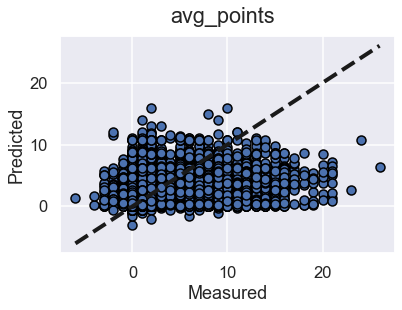

In [371]:
#How well does avg_points along over the previous 5 games predict points earned? not as well as our forecast.

fig, ax = plt.subplots()
ax.scatter(players.total_points, players.avg_points, edgecolors=(0, 0, 0))
ax.plot([players.total_points.min(), players.total_points.max()], [players.total_points.min(), players.total_points.max()], 'k--', lw=4)
fig.suptitle('avg_points')
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

## settle on Decision Tree Regressor

In [382]:
#adding the player name doesn't substantially improve our model
#we'll leave it out, since that keeps our model more general and easier to work with
features = players[feature_cols_no_name]

In [383]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=.2, random_state=4)

In [384]:
clf = DecisionTreeRegressor()

In [385]:
clf.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [386]:
predictions = pd.DataFrame()
predictions['pred'] = list(clf.predict(X_test))
predictions['actual'] = list(y_test)

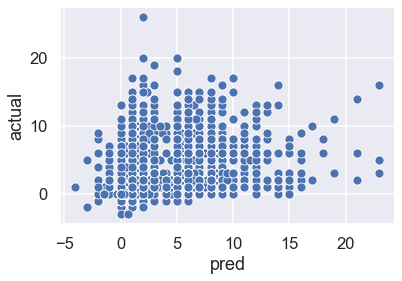

In [387]:
sns.scatterplot(x='pred', y='actual', data=predictions)

In [388]:
#mse of test data

mean_squared_error(predictions.actual,predictions.pred)

6.212761850103111

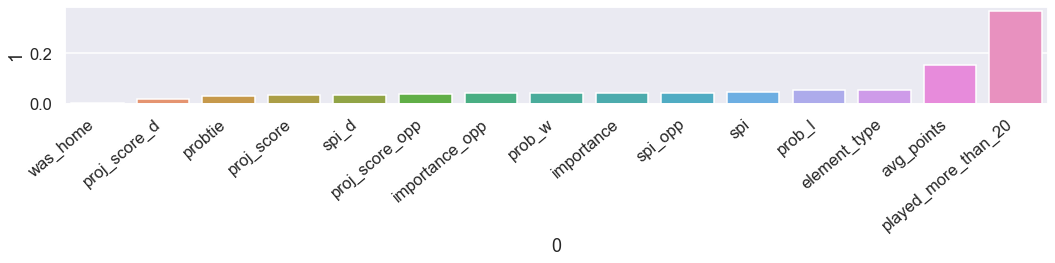

In [389]:
## Look at feature importance in CLF

data = pd.DataFrame(zip(list(features), clf.feature_importances_))
data = data.sort_values(1)
plt.figure(figsize=(15,4))
ax = sns.barplot(x=0, y=1, data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()

In [390]:
players['clf_pred'] = list(clf.predict(features))
players['total_points'] = players.total_points.astype('float')
players['clf_pred'] = players.clf_pred.astype('float')

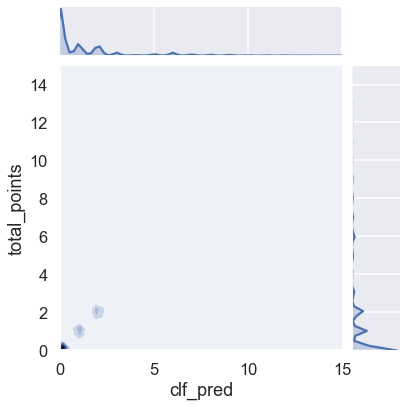

In [391]:
sns.set_style('darkgrid')
sns.set('talk')
sns.jointplot(data=players, x='clf_pred', y='total_points', kind='kde', xlim=(0,15), ylim=(0,15))


In [392]:
mean_squared_error(players.clf_pred,players.total_points)

1.3921764120127613

In [393]:
data = players.groupby('name')[['total_points', 'clf_pred']].sum()

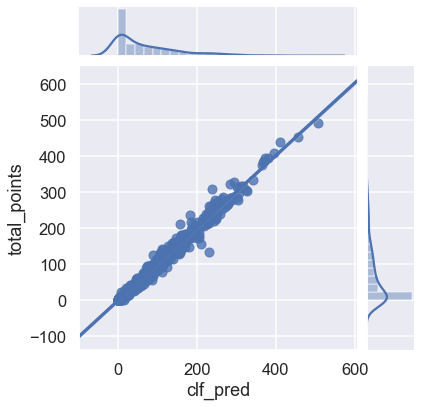

In [394]:
sns.set_style('darkgrid')
sns.set('talk')
sns.jointplot(data=data, x='clf_pred', y='total_points', kind='reg')


In [395]:
mean_absolute_error(data.clf_pred, data.total_points)

5.711973575557391

23.87313253012047

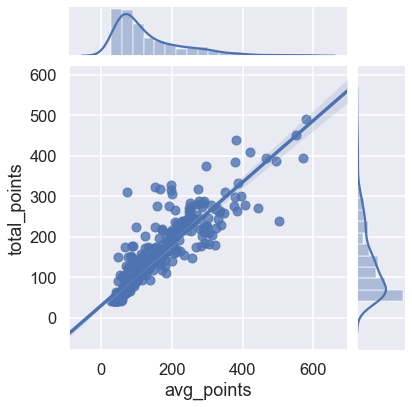

In [77]:
#what would a season long estimate look like if we only used avg_points as our indicator? not as good

data = players.groupby('name')[['total_points', 'avg_points']].sum()
sns.set_style('darkgrid')
sns.set('talk')
sns.jointplot(data=data, x='avg_points', y='total_points', kind='reg')
mean_absolute_error(data.avg_points, data.total_points)

# Make Predictions for 2020-2021 Season

In [ ]:
#should instead use the GW csvs, so we have data from each of the gameweeks played so far, and add SPI data only for the unplayed weeks

In [425]:
season = pd.read_csv('/Users/andrewjpeters/Documents/GitHub/fpl/data/2020-21/gws/gw3.csv')

In [416]:
season = season[['name', 'position', 'team', 'value', 'total_points', 'minutes']]

In [417]:
spi.head()

date            team              team_opp    spi  spi_opp  \
12  2016-08-13       Hull City             Leicester  53.57    66.81   
13  2016-08-13  Crystal Palace  West Bromwich Albion  55.19    58.66   
14  2016-08-13         Everton             Tottenham  68.02    73.25   
15  2016-08-13   Middlesbrough            Stoke City  56.32    60.35   
16  2016-08-13         Burnley          Swansea City  58.98    59.74   

    proj_score  proj_score_opp  prob_w  prob_l  probtie  importance  \
12        1.16            1.24  0.3459  0.3621   0.2921        38.1   
13        1.35            1.14  0.4214  0.2939   0.2847        43.6   
14        1.47            1.38  0.3910  0.3401   0.2689        31.9   
15        1.30            1.01  0.4380  0.2692   0.2927        33.9   
16        1.37            1.05  0.4482  0.2663   0.2854        36.5   

    importance_opp  
12            22.2  
13            34.6  
14            48.0  
15            32.5  
16            29.1

In [418]:
spi_2020 = spi[(spi['date'] > '2020-09-01') & (spi['date'] < '2021-06-01')]

In [419]:
for team in list(spi_2020.team.unique()):
    if not team in list(season.team):
        print(team)

West Bromwich Albion
Tottenham
Sheffield United
Leeds United
Man United


In [420]:
season = season.replace({'Man Utd': 'Man United',
        'Spurs': 'Tottenham',
        'Sheffield Utd': 'Sheffield United',
        'West Brom': 'West Bromwich Albion',
        'Leeds': 'Leeds United'})

In [421]:
df = pd.DataFrame()
for name in season.name.unique():
    part = season[season['name'] == name]
    part = part.merge(spi_2020, how='right', on='team')
    df = df.append(part)

In [422]:
df.head()

name position      team  value  total_points  minutes  \
0  Aaron Connolly      FWD  Brighton   55.0           2.0     73.0   
1  Aaron Connolly      FWD  Brighton   55.0           2.0     73.0   
2  Aaron Connolly      FWD  Brighton   55.0           2.0     73.0   
3  Aaron Connolly      FWD  Brighton   55.0           2.0     73.0   
4  Aaron Connolly      FWD  Brighton   55.0           2.0     73.0   

         date              team_opp    spi  spi_opp  proj_score  \
0  2020-09-14               Chelsea  68.03    85.37        1.02   
1  2020-09-26            Man United  70.26    85.38        1.00   
2  2020-10-26  West Bromwich Albion  70.38    58.34        1.74   
3  2020-11-07               Burnley  70.38    67.75        1.52   
4  2020-11-28             Liverpool  70.38    88.81        1.20   

   proj_score_opp  prob_w  prob_l  probtie  importance  importance_opp  
0            1.93  0.1944  0.5806   0.2249        28.3            61.0  
1            1.75  0.2135  0.5444   0.2421        20.9            55.4  
2            0.93  0.5603  0.1979   0.2418         NaN             NaN  
3            1.12  0.4603  0.2771   0.2626         NaN             NaN  
4            2.24  0.1934  0.6040   0.2025         NaN             NaN

In [424]:
season.sort_values('name')

name position              team  value  total_points  \
0           Aaron Connolly      FWD          Brighton     55             2   
1          Aaron Cresswell      DEF          West Ham     49             7   
2               Aaron Mooy      MID          Brighton     50             0   
3           Aaron Ramsdale       GK  Sheffield United     50             4   
4        Aaron Wan-Bissaka      DEF        Man United     55             1   
..                     ...      ...               ...    ...           ...   
549          Yves Bissouma      MID          Brighton     45             0   
550           Zack Steffen       GK          Man City     45             0   
551  Zeze Steven Sessegnon      DEF            Fulham     44             0   
552         Çaglar Söyüncü      DEF         Leicester     55             0   
553           Ørjan Nyland       GK       Aston Villa     40             0   

     minutes  
0         73  
1         90  
2          0  
3         90  
4         90  
..       ...  
549        0  
550        0  
551        0  
552       90  
553        0  

[554 rows x 6 columns]

In [207]:
# what columns do we need to add to df to match the players dataframe
for col in list(players):
    if not col in list(df):
        print(col)

element
element_type
was_home
season
spi_d
proj_score_d
avg_points
played_more_than_20
name_code
clf_pred


In [208]:
df['season'] = 2020

In [209]:
#for now, let's assume that everyone in df is healthy, and will play more than 20 minutes per game. 
df['played_more_than_20'] = 1

In [210]:
#element_type is position, with GK = 1, Defender = 2, and so on

In [211]:
df.position.unique()

array(['FWD', nan, 'DEF', 'MID', 'GK'], dtype=object)

In [212]:
df = df.replace({
    'GK': 1,
    'DEF': 2,
    'MID': 3,
    'FWD': 4
})

In [213]:
# We'll assume player's current values will hold, and will be their value for the rest of the season.
# In the future, it would be worth adding an ability to update these values from the fpl website directly to keep everything UTD
df = df.merge(season[['name', 'value']], how='left', on='name')

In [255]:
# "Element" is the player id from the FPL site, but we're not currently using this for anything -- no need to add now

In [256]:
#avg_points: I'm going to calculate this using the first 3 games of this season, plus the average of the last 5 from last season. First 3 from this season will take 70% wt, and last 5 from last season will take 30% wt. This is a bit arbitrary, but my thinking is that as straight average of the last 5 games would put 60% wt on the first 3 from this season (at 20% per game, split evenly) -- this gives some recency bias towards the new season, but just a bit, since last season has a much large sample size.

In [214]:
#need to add whether or not the game was home
#because 'was home' was shown to have very low importance in the CLF, I'm going to mark all games as home for the time being
df['was_home'] = True

In [215]:
#spi_d & proj_score_d is simple math, can be added using current columns
df['spi_d'] = df['spi'] - df['spi_opp']
df['proj_score_d'] = df['proj_score'] - df['proj_score_opp']

In [216]:
df[df.importance.isnull()]

name  position      team  value_x  total_points        date  \
2       Aaron Connolly       4.0  Brighton     55.0           2.0  2020-10-26   
3       Aaron Connolly       4.0  Brighton     55.0           2.0  2020-11-07   
4       Aaron Connolly       4.0  Brighton     55.0           2.0  2020-11-28   
5       Aaron Connolly       4.0  Brighton     55.0           2.0  2020-12-05   
6       Aaron Connolly       4.0  Brighton     55.0           2.0  2020-12-19   
...                ...       ...       ...      ...           ...         ...   
421035             NaN       NaN    Wolves      NaN           NaN  2021-03-20   
421036             NaN       NaN    Wolves      NaN           NaN  2021-04-10   
421037             NaN       NaN    Wolves      NaN           NaN  2021-05-01   
421038             NaN       NaN    Wolves      NaN           NaN  2021-05-12   
421039             NaN       NaN    Wolves      NaN           NaN  2021-05-15   

                    team_opp    spi  spi_opp  proj_score  proj_score_opp  \
2       West Bromwich Albion  70.38    58.34        1.74            0.93   
3                    Burnley  70.38    67.75        1.52            1.12   
4                  Liverpool  70.38    88.81        1.20            2.24   
5                Southampton  70.38    72.31        1.44            1.27   
6           Sheffield United  70.38    67.39        1.43            0.98   
...                      ...    ...      ...         ...             ...   
421035              Man City  75.81    92.02        0.73            2.29   
421036                Fulham  75.81    60.70        1.36            1.02   
421037  West Bromwich Albion  75.81    58.34        1.41            0.96   
421038             Tottenham  75.81    81.30        0.99            1.62   
421039               Everton  75.81    76.89        1.05            1.42   

        prob_w  prob_l  probtie  importance  importance_opp  season  \
2       0.5603  0.1979   0.2418         NaN             NaN    2020   
3       0.4603  0.2771   0.2626         NaN             NaN    2020   
4       0.1934  0.6040   0.2025         NaN             NaN    2020   
5       0.4072  0.3293   0.2635         NaN             NaN    2020   
6       0.4706  0.2558   0.2736         NaN             NaN    2020   
...        ...     ...      ...         ...             ...     ...   
421035  0.1022  0.7209   0.1769         NaN             NaN    2020   
421036  0.4435  0.2768   0.2797         NaN             NaN    2020   
421037  0.4675  0.2554   0.2771         NaN             NaN    2020   
421038  0.2294  0.5159   0.2548         NaN             NaN    2020   
421039  0.2760  0.4514   0.2726         NaN             NaN    2020   

        played_more_than_20  value_y  was_home  spi_d  proj_score_d  
2                         1     55.0      True  12.04          0.81  
3                         1     55.0      True   2.63          0.40  
4                         1     55.0      True -18.43         -1.04  
5                         1     55.0      True  -1.93          0.17  
6                         1     55.0      True   2.99          0.45  
...                     ...      ...       ...    ...           ...  
421035                    1      NaN      True -16.21         -1.56  
421036                    1      NaN      True  15.11          0.34  
421037                    1      NaN      True  17.47          0.45  
421038                    1      NaN      True  -5.49         -0.63  
421039                    1      NaN      True  -1.08         -0.37  

[365640 rows x 22 columns]

In [217]:
#estimate importance using median importance by team
importance = df.groupby('team')['importance', 'importance_opp'].median().reset_index()

In [218]:
df = df.merge(importance, how='left', on='team')

In [219]:
df.head()

name  position      team  value_x  total_points        date  \
0  Aaron Connolly       4.0  Brighton     55.0           2.0  2020-09-14   
1  Aaron Connolly       4.0  Brighton     55.0           2.0  2020-09-26   
2  Aaron Connolly       4.0  Brighton     55.0           2.0  2020-10-26   
3  Aaron Connolly       4.0  Brighton     55.0           2.0  2020-11-07   
4  Aaron Connolly       4.0  Brighton     55.0           2.0  2020-11-28   

               team_opp    spi  spi_opp  proj_score  proj_score_opp  prob_w  \
0               Chelsea  68.03    85.37        1.02            1.93  0.1944   
1            Man United  70.26    85.38        1.00            1.75  0.2135   
2  West Bromwich Albion  70.38    58.34        1.74            0.93  0.5603   
3               Burnley  70.38    67.75        1.52            1.12  0.4603   
4             Liverpool  70.38    88.81        1.20            2.24  0.1934   

   prob_l  probtie  importance_x  importance_opp_x  season  \
0  0.5806   0.2249          28.3              61.0    2020   
1  0.5444   0.2421          20.9              55.4    2020   
2  0.1979   0.2418           NaN               NaN    2020   
3  0.2771   0.2626           NaN               NaN    2020   
4  0.6040   0.2025           NaN               NaN    2020   

   played_more_than_20  value_y  was_home  spi_d  proj_score_d  importance_y  \
0                    1     55.0      True -17.34         -0.91          25.9   
1                    1     55.0      True -15.12         -0.75          25.9   
2                    1     55.0      True  12.04          0.81          25.9   
3                    1     55.0      True   2.63          0.40          25.9   
4                    1     55.0      True -18.43         -1.04          25.9   

   importance_opp_y  
0              41.9  
1              41.9  
2              41.9  
3              41.9  
4              41.9

In [220]:
#where 538 estimated importance (in importance_x colums), use those values
#where those values are missing, using median estimate (importance_y_columns)

df.loc[df['importance_x'].isnull(),'importance_x'] = df['importance_y']
df.loc[df['importance_opp_x'].isnull(),'importance_opp_x'] = df['importance_opp_y']

In [221]:
df = df.drop(columns=['importance_y', 'importance_opp_y'])

In [222]:
df = df.rename(columns={'importance_x': 'importance',
                       'importance_opp_x': 'importance_opp'})

In [223]:
avg_points_2020 = season.groupby('name')['total_points'].mean().reset_index()

In [279]:
last_five = players.sort_values(['name', 'date']).groupby(['name']).tail(10)
avg_points_2019 = last_five.groupby('name')['total_points'].mean().reset_index()

In [280]:
avg_points = avg_points_2020.merge(avg_points_2019, on='name', how='left', suffixes=['2020','2019'])

In [281]:
avg_points.head()

name  total_points2020  total_points2019
0     Aaron Connolly                 2               2.0
1    Aaron Cresswell                 7               1.8
2         Aaron Mooy                 0               1.9
3     Aaron Ramsdale                 4               3.2
4  Aaron Wan-Bissaka                 1               4.9

In [282]:
avg_points['weighted'] = (avg_points['total_points2020']*.5) + (avg_points['total_points2019']*.5)

In [283]:
avg_points.tail()

name  total_points2020  total_points2019  weighted
549          Yves Bissouma                 0               1.4      0.70
550           Zack Steffen                 0               NaN       NaN
551  Zeze Steven Sessegnon                 0               NaN       NaN
552         Çaglar Söyüncü                 0               2.3      1.15
553           Ørjan Nyland                 0               NaN       NaN

In [284]:
#there are going to be so NaN for players in our 2020 list than don't have data from our 2019 list
#for these players, we can just use the avg from the first 3 games of 2020 as our average
avg_points.loc[avg_points['weighted'].isnull(),'weighted'] = avg_points['total_points2020']

In [301]:
df = df.merge(avg_points[['name', 'weighted']], on='name')

In [302]:
df = df.rename(columns={'weighted': 'avg_points'})

In [303]:
df.isnull().sum()

name                   0
element_type           0
team                   0
value_x                0
total_points           0
date                   0
team_opp               0
spi                    0
spi_opp                0
proj_score             0
proj_score_opp         0
prob_w                 0
prob_l                 0
probtie                0
importance             0
importance_opp         0
season                 0
played_more_than_20    0
value_y                0
was_home               0
spi_d                  0
proj_score_d           0
clf_pred               0
avg_points             0
dtype: int64

In [288]:
df = df.rename(columns={'position': 'element_type'})

In [396]:
X = df[feature_cols_no_name]

In [397]:
y = clf.predict(X)

In [398]:
df['clf_pred'] = y

In [399]:
df.head()

name  element_type      team  value_x  total_points        date  \
0  Aaron Connolly           4.0  Brighton     55.0           2.0  2020-09-14   
1  Aaron Connolly           4.0  Brighton     55.0           2.0  2020-09-26   
2  Aaron Connolly           4.0  Brighton     55.0           2.0  2020-10-26   
3  Aaron Connolly           4.0  Brighton     55.0           2.0  2020-11-07   
4  Aaron Connolly           4.0  Brighton     55.0           2.0  2020-11-28   

               team_opp    spi  spi_opp  proj_score  proj_score_opp  prob_w  \
0               Chelsea  68.03    85.37        1.02            1.93  0.1944   
1            Man United  70.26    85.38        1.00            1.75  0.2135   
2  West Bromwich Albion  70.38    58.34        1.74            0.93  0.5603   
3               Burnley  70.38    67.75        1.52            1.12  0.4603   
4             Liverpool  70.38    88.81        1.20            2.24  0.1934   

   prob_l  probtie  importance  importance_opp  season  played_more_than_20  \
0  0.5806   0.2249        28.3            61.0    2020                    1   
1  0.5444   0.2421        20.9            55.4    2020                    1   
2  0.1979   0.2418        25.9            41.9    2020                    1   
3  0.2771   0.2626        25.9            41.9    2020                    1   
4  0.6040   0.2025        25.9            41.9    2020                    1   

   value_y  was_home  spi_d  proj_score_d  clf_pred  avg_points  
0     55.0      True -17.34         -0.91       2.0         2.0  
1     55.0      True -15.12         -0.75       1.0         2.0  
2     55.0      True  12.04          0.81       2.0         2.0  
3     55.0      True   2.63          0.40       6.0         2.0  
4     55.0      True -18.43         -1.04       2.0         2.0

In [400]:
df.groupby(['name', 'element_type', 'team', 'value_x'])['clf_pred'].sum().reset_index()

name  element_type              team  value_x  \
0           Aaron Connolly           4.0          Brighton     55.0   
1          Aaron Cresswell           2.0          West Ham     49.0   
2               Aaron Mooy           3.0          Brighton     50.0   
3           Aaron Ramsdale           1.0  Sheffield United     50.0   
4        Aaron Wan-Bissaka           2.0        Man United     55.0   
..                     ...           ...               ...      ...   
549          Yves Bissouma           3.0          Brighton     45.0   
550           Zack Steffen           1.0          Man City     45.0   
551  Zeze Steven Sessegnon           2.0            Fulham     44.0   
552         Çaglar Söyüncü           2.0         Leicester     55.0   
553           Ørjan Nyland           1.0       Aston Villa     40.0   

       clf_pred  
0     82.000000  
1    107.000000  
2    129.500000  
3    122.000000  
4    118.000000  
..          ...  
549   96.000000  
550  256.500000  
551   90.666667  
552  106.000000  
553  114.000000  

[554 rows x 5 columns]

In [259]:
# next steps
# compare using name vs. not using name to see if dealing with name is worthwhile
# look into using one-hot encoding to deal with player names
# estimate player points of 20-21 season
# when estimating player points --> it's preferable to pick players that have a high probablility of a strong return on points, rather than a lower probability of getting an absurd amount of points
# solve kapsack problem

In [325]:
#try solving knapsack problem using predicted numbers on season 19

In [163]:
season_19 = players[(players.date > '2019-08-08')]

In [164]:
season_19 = season_19.groupby(['name', 'element_type', 'team'])['clf_pred', 'total_points'].sum().reset_index()

In [166]:
season_19_values = players[(players.date > '2019-08-08')].sort_values(['name', 'date']).drop_duplicates(subset='name', keep='first')[['name', 'value']]

In [167]:
season_19 = season_19.merge(season_19_values, on='name')

In [401]:
data = df.groupby(['name', 'element_type', 'team', 'value_x'])['clf_pred'].sum().reset_index()
expected_scores = data.clf_pred.values
prices = data.value_x.values / 10
positions = data.element_type.values
clubs = data.team.values
names = data.name.values
decisions, captain_decisions, sub_decisions = select_team(expected_scores, prices, positions, clubs)

Total expected score = 3204.2999999999997


In [402]:
data.sort_values('clf_pred', ascending=False)

name  element_type          team  value_x  clf_pred
313  Kevin De Bruyne           3.0      Man City    116.0     302.0
243      Jamie Vardy           4.0     Leicester    100.0     281.0
479       Sadio Mané           3.0     Liverpool    119.0     269.0
43   Anthony Martial           4.0    Man United     90.0     266.0
508    Tammy Abraham           4.0       Chelsea     73.0     258.5
..               ...           ...           ...      ...       ...
55     Barry Douglas           2.0  Leeds United     40.0      45.0
137   Diego Llorente           2.0  Leeds United     45.0      45.0
421     Oliver Casey           2.0  Leeds United     40.0      45.0
328       Leif Davis           2.0  Leeds United     40.0      45.0
434   Pascal Struijk           2.0  Leeds United     40.0      45.0

[554 rows x 5 columns]

In [403]:
chosen_names = []
chosen_points = []
chosen_position = []
actual_points = []
for i in range(len(data)):
    if decisions[i].value() !=0:
        chosen_names.append(names[i])
        chosen_points.append(expected_scores[i])
        chosen_position.append(positions[i])
chosen_ones = pd.DataFrame(zip(chosen_names, chosen_points, chosen_position), columns=['name', 'pred', 'pos'])

sub_names = []
sub_points = []
sub_position = []
actual_points = []
for i in range(len(data)):
    if sub_decisions[i].value() !=0:
        sub_names.append(names[i])
        sub_points.append(expected_scores[i])
        sub_position.append(positions[i])
subs = pd.DataFrame(zip(sub_names, sub_points, sub_position), columns=['name', 'pred', 'pos'])

In [404]:
chosen_ones

name   pred  pos
0                 Anthony Martial  266.0  4.0
1                 Conor Hourihane  235.5  3.0
2                      Diogo Jota  249.0  3.0
3                     Eric Garcia  242.5  2.0
4                     Jamie Vardy  281.0  4.0
5                     John Stones  232.0  2.0
6                 Kevin De Bruyne  302.0  3.0
7                   Michael Keane  200.0  2.0
8   Rui Pedro dos Santos Patrício  230.0  1.0
9                      Sadio Mané  269.0  3.0
10                  Tammy Abraham  258.5  4.0

In [405]:
subs

name   pred  pos
0   David Button  171.0  1.0
1   Ethan Ampadu  177.5  2.0
2  Jack Robinson  177.5  2.0
3  Steven Alzate  158.0  3.0

In [413]:
chosen_ones.merge(players[players.name.isin(chosen_ones.name)].groupby('name')['total_points'].sum().reset_index(), on='name')

name   pred  pos  total_points
0                 Anthony Martial  266.0  4.0         322.0
1                 Conor Hourihane  235.5  3.0          83.0
2                      Diogo Jota  249.0  3.0         244.0
3                     Eric Garcia  242.5  2.0          38.0
4                     Jamie Vardy  281.0  4.0         384.0
5                     John Stones  232.0  2.0         117.0
6                 Kevin De Bruyne  302.0  3.0         310.0
7                   Michael Keane  200.0  2.0         219.0
8   Rui Pedro dos Santos Patrício  230.0  1.0         271.0
9                      Sadio Mané  269.0  3.0         452.0
10                  Tammy Abraham  258.5  4.0         153.0

In [ ]:
#Red flags for large discrepancies between last year's total points and predicted points this year -- this could be from assuming that everyone is playing over 20 minutes


In [170]:
import pulp

In [183]:
def select_team(expected_scores, prices, positions, clubs, total_budget=100, sub_factor=0.2):
    num_players = len(expected_scores)
    model = pulp.LpProblem("Constrained value maximisation", pulp.LpMaximize)
    decisions = [
        pulp.LpVariable("x{}".format(i), lowBound=0, upBound=1, cat='Integer')
        for i in range(num_players)
    ]
    captain_decisions = [
        pulp.LpVariable("y{}".format(i), lowBound=0, upBound=1, cat='Integer')
        for i in range(num_players)
    ]
    sub_decisions = [
        pulp.LpVariable("z{}".format(i), lowBound=0, upBound=1, cat='Integer')
        for i in range(num_players)
    ]


    # objective function:
    model += sum((captain_decisions[i] + decisions[i] + sub_decisions[i]*sub_factor) * expected_scores[i]
                 for i in range(num_players)), "Objective"

    # cost constraint
    model += sum((decisions[i] + sub_decisions[i]) * prices[i] for i in range(num_players)) <= total_budget  # total cost

    # position constraints
    # 1 starting goalkeeper
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 1) == 1
    # 2 total goalkeepers
    model += sum(decisions[i] + sub_decisions[i] for i in range(num_players) if positions[i] == 1) == 2

    # 3-5 starting defenders
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 2) >= 3
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 2) <= 5
    # 5 total defenders
    model += sum(decisions[i] + sub_decisions[i] for i in range(num_players) if positions[i] == 2) == 5

    # 3-5 starting midfielders
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 3) >= 3
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 3) <= 5
    # 5 total midfielders
    model += sum(decisions[i] + sub_decisions[i] for i in range(num_players) if positions[i] == 3) == 5

    # 1-3 starting attackers
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 4) >= 1
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 4) <= 3
    # 3 total attackers
    model += sum(decisions[i] + sub_decisions[i] for i in range(num_players) if positions[i] == 4) == 3

    # club constraint
    for club_id in np.unique(clubs):
        model += sum(decisions[i] + sub_decisions[i] for i in range(num_players) if clubs[i] == club_id) <= 3  # max 3 players

    model += sum(decisions) == 11  # total team size
    model += sum(captain_decisions) == 1  # 1 captain
    
    for i in range(num_players):  
        model += (decisions[i] - captain_decisions[i]) >= 0  # captain must also be on team
        model += (decisions[i] + sub_decisions[i]) <= 1  # subs must not be on team

    model.solve()
    print("Total expected score = {}".format(model.objective.value()))

    return decisions, captain_decisions, sub_decisions

In [184]:
list(season_19)

['name', 'element_type', 'team', 'clf_pred', 'total_points', 'value']

In [185]:
expected_scores = season_19.clf_pred.values
prices = season_19.value.values / 10
positions = season_19.element_type.values
clubs = season_19.team.values
decisions, captain_decisions, sub_decisions = select_team(expected_scores, prices, positions, clubs)

Total expected score = 2428.4700000000003


In [186]:
names = season_19.name.values

In [191]:
chosen_names = []
chosen_points = []
chosen_position = []
actual_points = []
for i in range(len(season_19)):
    if decisions[i].value() !=0:
        chosen_names.append(names[i])
        chosen_points.append(expected_scores[i])
        chosen_position.append(positions[i])
        actual_points.append(season_19.total_points.values[i])
chosen_ones = pd.DataFrame(zip(chosen_names, chosen_points, chosen_position, actual_points), columns=['name', 'pred', 'pos', 'actual'])

sub_names = []
sub_points = []
sub_position = []
actual_points = []
for i in range(len(season_19)):
    if sub_decisions[i].value() !=0:
        sub_names.append(names[i])
        sub_points.append(expected_scores[i])
        sub_position.append(positions[i])
        actual_points.append(season_19.total_points.values[i])
subs = pd.DataFrame(zip(sub_names, sub_points, sub_position, actual_points), columns=['name', 'pred', 'pos', 'actual'])

In [192]:
chosen_ones = pd.DataFrame(zip(chosen_names, chosen_points, chosen_position, actual_points), columns=['name', 'pred', 'pos', 'actual'])

In [193]:
chosen_ones

name   pred  pos  actual
0          Anthony Martial  186.5    3   200.0
1               Danny Ings  189.5    4   198.0
2           Dean Henderson  171.5    1   160.0
3           George Baldock  137.5    2   142.0
4              Jamie Vardy  193.0    4   210.0
5              Mason Mount  145.0    3   137.0
6             Matt Doherty  152.0    2   167.0
7            Mohamed Salah  252.0    3   233.0
8             Raúl Jiménez  179.0    4   194.0
9               Sadio Mané  236.0    3   221.0
10  Trent Alexander-Arnold  227.0    2   210.0

In [194]:
sub_names = []
sub_points = []
sub_position = []
actual_points = []
for i in range(len(season_19)):
    if sub_decisions[i].value() !=0:
        sub_names.append(names[i])
        sub_points.append(expected_scores[i])
        sub_position.append(positions[i])
        actual_points.append(season_19.total_points.values[i])

In [195]:
sub_ones = pd.DataFrame(zip(sub_names, sub_points, sub_position, actual_points), columns=['name', 'pred', 'pos', 'actual'])

In [196]:
sub_ones

name    pred  pos  actual
0    Adama Traoré  137.35    3   130.0
1  John Lundstram  121.00    2   144.0
2      Lewis Dunk  131.00    2   128.0
3       Nick Pope  148.00    1   170.0